In [ ]:
import re
import pandas as pd
import itertools
from io import StringIO
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import zipfile
import time
import shutil


DATA_ROOT = Path("../data")
output_path = "../data/dsa_processed/discord_cleaned_subset.parquet"

MONTHS = {
    "jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
    "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12
}

# remove columns we don't need for analysis
COLUMNS = [
    "account_type", # can we filter out servers with this?
    "application_date", # enforcement date
    "automated_decision", # needed?
    "automated_detection", # proactive vs reactive (whether the content was detected using automated means)
    "decision_ground",  # reason for the decision
    "decision_facts", # more details on the decision, look for keyword server here?
    "category", # violation category, map DSA categories to Discord ones
    "category_specification", # sub category
    "content_type", # The type of content acted on (e.g. text, image, video).
    "content_type_other", # further specification if content_type is "other"
    "content_date", # when the content was originally published / made available.
    "source_type", # how the content was identified (e.g. user report, automated detection).
]

CATEGORY_MAPPING = {
    'STATEMENT_CATEGORY_SCAMS_AND_FRAUD': "Scams and Fraud",
    'STATEMENT_CATEGORY_PROTECTION_OF_MINORS': "Protection of minors",                  
    'STATEMENT_CATEGORY_VIOLENCE': "Violence",                                
    'STATEMENT_CATEGORY_CYBER_VIOLENCE': "Cyber Violence",                        
    'STATEMENT_CATEGORY_ILLEGAL_OR_HARMFUL_SPEECH': "Illegal or harmful speech",
    'STATEMENT_CATEGORY_RISK_FOR_PUBLIC_SECURITY': "Risk for public security",                 
    'STATEMENT_CATEGORY_OTHER_VIOLATION_TC': "Other violarion TC",                       
    'STATEMENT_CATEGORY_SELF_HARM': 'Self harm',   
    'STATEMENT_CATEGORY_INTELLECTUAL_PROPERTY_INFRINGEMENTS': "Intellectual property infringements",
    'STATEMENT_CATEGORY_UNSAFE_AND_PROHIBITED_PRODUCTS': "Unsafe and prohibited products"
}

### Download full Discord DSA data

In [24]:
# Base URL of the DSA Transparency Portal
base_url = "https://transparency.dsa.ec.europa.eu/explore-data/download"
platform_id = 59  # Discord
page = 1  # Start from the first page

os.makedirs('../data/dsa_zip_files', exist_ok=True)
os.makedirs('../data/dsa_extracted', exist_ok=True)

def unzip_recursive(folder_path):
    """
    Recursively unzip all zip files in a folder and its subfolders
    """
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".zip"):
                zip_path = os.path.join(root, file)
                extract_folder = os.path.join(root, file.replace(".zip", ""))
                if not os.path.exists(extract_folder):
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(extract_folder)
                    print(f"Extracted {zip_path} -> {extract_folder}")
                    # After extracting, recursively unzip inside
                    unzip_recursive(extract_folder)

def concatenate_csvs(folder_path, output_filename):
    """
    Concatenate all CSVs in a folder (and its subfolders) into a single CSV
    """
    all_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".csv"):
                all_files.append(os.path.join(root, file))
    if all_files:
        df_list = [pd.read_csv(f) for f in all_files]
        combined_df = pd.concat(df_list, ignore_index=True)
        combined_df.to_csv(output_filename, index=False)
        print(f"Concatenated {len(all_files)} CSVs into {output_filename}")
    else:
        print(f"No CSV files found in {folder_path}")

while True:
    print(f"Processing page {page}...")
    params = {"platform_id": platform_id, "page": page}
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find all ZIP links in the "full" column
    links = soup.find_all('a', href=True)
    zip_links = [link['href'] for link in links if 'full' in link['href'] and link['href'].endswith('.zip')]
    
    if not zip_links:
        print("No more ZIP files found. Finished downloading all pages.")
        break
    
    for zip_url in zip_links:
        zip_filename = os.path.join('../data/dsa_zip_files', zip_url.split('/')[-1])
        extract_folder = os.path.join('../data/dsa_extracted', zip_url.split('/')[-1].replace('.zip', ''))

        # sanity check
        if not os.path.exists(zip_filename):
            print(f"Downloading {zip_filename}...")
            zip_response = requests.get(zip_url)
            zip_response.raise_for_status()
            with open(zip_filename, 'wb') as f:
                f.write(zip_response.content)
            print(f"Downloaded {zip_filename}")
        else:
            print(f"{zip_filename} already exists. Skipping download.")
        
        if not os.path.exists(extract_folder):
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                zip_ref.extractall(extract_folder)
            print(f"Extracted to {extract_folder}")
        else:
            print(f"{extract_folder} already exists. Skipping extraction.")
        
        # unzip nested zips
        unzip_recursive(extract_folder)
        
        # concatenate data for each day (folder) in a new csv
        output_csv = os.path.join('../data/dsa_extracted', zip_url.split('/')[-1].replace('.zip', '_combined.csv'))
        if(not os.path.exists(output_csv)):
            concatenate_csvs(extract_folder, output_csv)
    
    page += 1
    time.sleep(1)

# concatenate all the days into one big csv
os.makedirs('../data/dsa_processed', exist_ok=True)

print("Concatenating all combined CSVs into one big dataset...")

# Collect all *_combined.csv files created earlier
daily_combined_files = [
    os.path.join('../data/dsa_extracted', f)
    for f in os.listdir('../data/dsa_extracted')
    if f.endswith('_combined.csv')
]

if daily_combined_files:
    df_list = [pd.read_csv(f, low_memory=False) for f in daily_combined_files]
    all_data = pd.concat(df_list, ignore_index=True)

    # Save to a single file (no date suffix)
    final_output = '../data/dsa_processed/all_discord_data_combined.csv'
    all_data.to_csv(final_output, index=False)
    print(f"All {len(daily_combined_files)} daily CSVs concatenated into {final_output}")
    print(f"Final shape: {all_data.shape}")
else:
    print("No per-day combined CSV files found in ../data/dsa_extracted/")

Processing page 1...
../data/dsa_zip_files/sor-discord-netherlands-bv-2025-10-14-full.zip already exists. Skipping download.
../data/dsa_extracted/sor-discord-netherlands-bv-2025-10-14-full already exists. Skipping extraction.
../data/dsa_zip_files/sor-discord-netherlands-bv-2025-10-13-full.zip already exists. Skipping download.
../data/dsa_extracted/sor-discord-netherlands-bv-2025-10-13-full already exists. Skipping extraction.
../data/dsa_zip_files/sor-discord-netherlands-bv-2025-10-12-full.zip already exists. Skipping download.
../data/dsa_extracted/sor-discord-netherlands-bv-2025-10-12-full already exists. Skipping extraction.
../data/dsa_zip_files/sor-discord-netherlands-bv-2025-10-11-full.zip already exists. Skipping download.
../data/dsa_extracted/sor-discord-netherlands-bv-2025-10-11-full already exists. Skipping extraction.
../data/dsa_zip_files/sor-discord-netherlands-bv-2025-10-10-full.zip already exists. Skipping download.
../data/dsa_extracted/sor-discord-netherlands-bv-20

In [25]:
# remove directories holding all zip files we dont need anymore
shutil.rmtree('../data/dsa_zip_files')
shutil.rmtree('../data/dsa_extracted')

### Filter out relevant columns and combine to parquet file

In [ ]:
path = final_output

df = pd.read_csv(
    path,
    usecols=lambda c: c in COLUMNS,
    dtype=str,          # treat all as strings to speed up parsing
    low_memory=False
)

print(f"Loaded dataframe with shape {df.shape}")

for col in ["content_date", "application_date", "created_at"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)

# optimize categorical cols
categorical_cols = [
    "decision_ground",
    "category",
    "automated_detection", "automated_decision"
]

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

print("Basic cleaning complete.")
df.to_parquet(output_path, index=False)
print(f"Cleaned + optimized dataset saved to {output_path}")


Loaded dataframe with shape (3421882, 12)
Basic cleaning complete.
Cleaned + optimized dataset saved to ../data/dsa_processed/discord_cleaned_subset.parquet


### Open Parquet dataset

In [24]:
# open parquet dataset
df = pd.read_parquet(output_path)
print(f"Loaded cleaned dataset with shape {df.shape}")

# print columns and their types
print("Columns and their data types:")
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

df.head()

Loaded cleaned dataset with shape (3421882, 12)
Columns and their data types:
account_type: object
decision_ground: category
category: category
category_specification: object
content_type: object
content_type_other: object
content_date: datetime64[ns, UTC]
application_date: datetime64[ns, UTC]
decision_facts: object
source_type: object
automated_detection: category
automated_decision: category


,account_type,decision_ground,category,category_specification,content_type,content_type_other,content_date,application_date,decision_facts,source_type,automated_detection,automated_decision
0,None,DECISION_GROUND_INCOMPATIBLE_CONTENT,STATEMENT_CATEGORY_PROTECTION_OF_MINORS,"[""KEYWORD_OTHER""]","[""CONTENT_TYPE_TEXT""]",None,2025-09-05 00:00:00+00:00,2025-09-10 00:00:00+00:00,This content was determined to violate our ter...,SOURCE_VOLUNTARY,No,AUTOMATED_DECISION_NOT_AUTOMATED
1,None,DECISION_GROUND_INCOMPATIBLE_CONTENT,STATEMENT_CATEGORY_PROTECTION_OF_MINORS,"[""KEYWORD_OTHER""]","[""CONTENT_TYPE_OTHER""]",User Account,2025-09-05 00:00:00+00:00,2025-09-10 00:00:00+00:00,This content was determined to violate our ter...,SOURCE_VOLUNTARY,No,AUTOMATED_DECISION_NOT_AUTOMATED
2,None,DECISION_GROUND_INCOMPATIBLE_CONTENT,STATEMENT_CATEGORY_PROTECTION_OF_MINORS,"[""KEYWORD_OTHER""]","[""CONTENT_TYPE_TEXT""]",None,2025-09-05 00:00:00+00:00,2025-09-10 00:00:00+00:00,This content was determined to violate our ter...,SOURCE_VOLUNTARY,No,AUTOMATED_DECISION_NOT_AUTOMATED
3,None,DECISION_GROUND_INCOMPATIBLE_CONTENT,STATEMENT_CATEGORY_PROTECTION_OF_MINORS,"[""KEYWORD_OTHER""]","[""CONTENT_TYPE_TEXT""]",None,2025-09-05 00:00:00+00:00,2025-09-10 00:00:00+00:00,This content was determined to violate our ter...,SOURCE_VOLUNTARY,No,AUTOMATED_DECISION_NOT_AUTOMATED
4,None,DECISION_GROUND_INCOMPATIBLE_CONTENT,STATEMENT_CATEGORY_PROTECTION_OF_MINORS,"[""KEYWORD_OTHER""]","[""CONTENT_TYPE_OTHER""]",User Account,2025-09-05 00:00:00+00:00,2025-09-10 00:00:00+00:00,This content was determined to violate our ter...,SOURCE_VOLUNTARY,No,AUTOMATED_DECISION_NOT_AUTOMATED


In [ ]:
# reorder dataset based on application date
df = df.sort_values(by="application_date")
df['category'].value_counts()

df['source_type'].unique

category
STATEMENT_CATEGORY_SCAMS_AND_FRAUD                        1769935
STATEMENT_CATEGORY_PROTECTION_OF_MINORS                   1049309
STATEMENT_CATEGORY_VIOLENCE                                233937
STATEMENT_CATEGORY_CYBER_VIOLENCE                          126287
STATEMENT_CATEGORY_ILLEGAL_OR_HARMFUL_SPEECH                98300
STATEMENT_CATEGORY_RISK_FOR_PUBLIC_SECURITY                 62770
STATEMENT_CATEGORY_OTHER_VIOLATION_TC                       55837
STATEMENT_CATEGORY_SELF_HARM                                17339
STATEMENT_CATEGORY_INTELLECTUAL_PROPERTY_INFRINGEMENTS       7044
STATEMENT_CATEGORY_UNSAFE_AND_PROHIBITED_PRODUCTS            1124
Name: count, dtype: int64

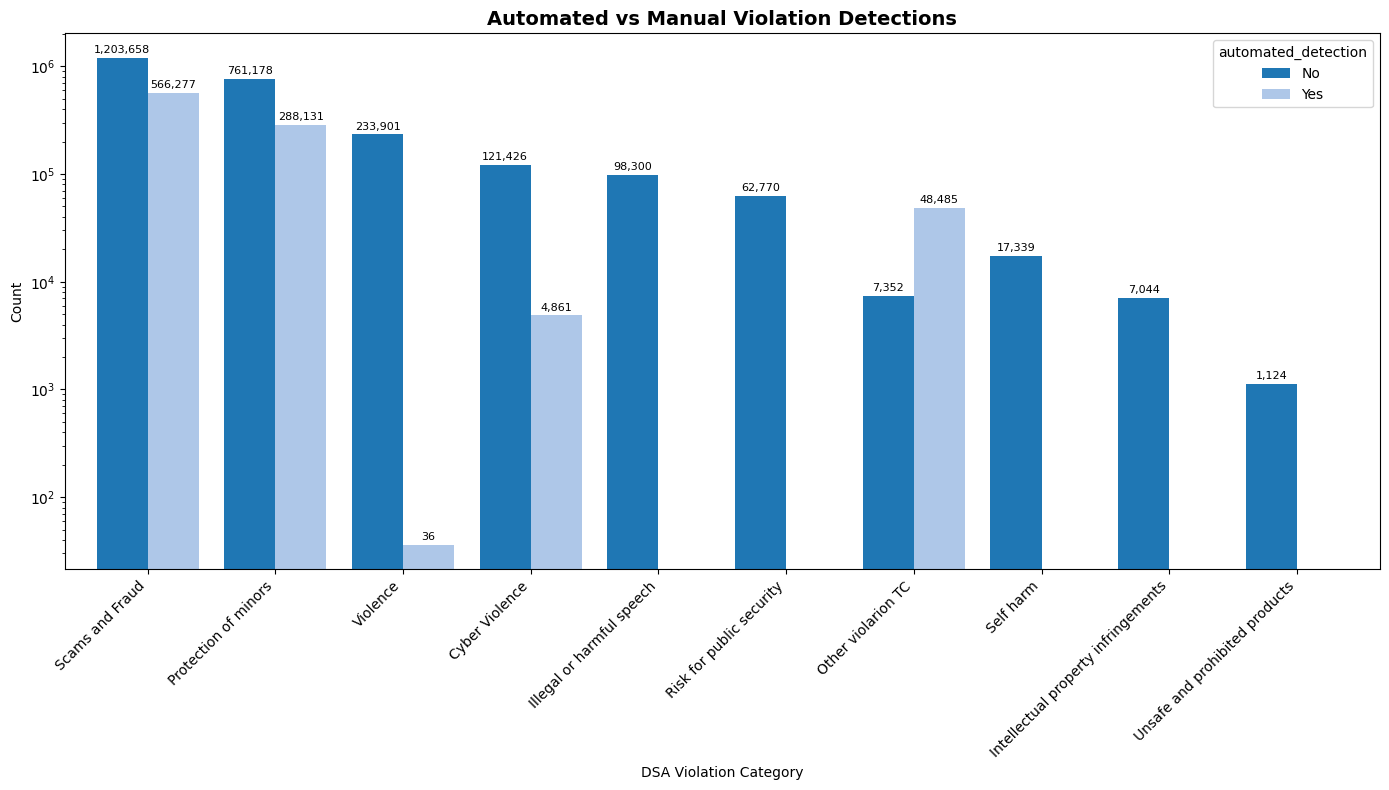

In [23]:
# histogram of automated decision vs manual decision for all categories
cmap = plt.get_cmap('tab20')

# prepare cross-tab of counts
cat_col = 'category'
dec_col = 'automated_detection' #'automated_decision'
ctab = pd.crosstab(
    df[cat_col].astype(str).fillna('Unknown'),
    df[dec_col].astype(str).fillna('Unknown')
)


top_idx = ctab.sum(axis=1).sort_values(ascending=False).index
ctab = ctab.loc[top_idx]

# ensure consistent color mapping (use first two colors)
colors = [cmap(0), cmap(1)] if ctab.shape[1] >= 2 else [cmap(0)]

fig, ax = plt.subplots(figsize=(14, 8))
ctab.plot(kind='bar', ax=ax, color=colors, width=0.8)

# map each x tick (category) through CATEGORY_MAPPING if available
def map_label(lbl):
    if lbl in CATEGORY_MAPPING:
        return CATEGORY_MAPPING[lbl]
    key = str(lbl).strip()
    if key.upper() in CATEGORY_MAPPING:
        return CATEGORY_MAPPING[key.upper()]
    return key

mapped_labels = [map_label(lbl) for lbl in ctab.index]

ax.set_yscale("log")
ax.set_ylabel('Count')
ax.set_xlabel("DSA Violation Category")
ax.set_title('Automated vs Manual Violation Detections', fontsize=14, weight='bold')
ax.legend(title=dec_col)
ax.set_xticklabels(mapped_labels, rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# optional: annotate counts on bars
for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.annotate(f"{int(h):,}", (p.get_x() + p.get_width()/2, h),
                    ha='center', va='bottom', fontsize=8, xytext=(0, 2),
                    textcoords='offset points')

plt.show()